# Continuous Control

---

In this notebook, DDPG agent is trained on Reacher environment.

In [2]:
%matplotlib inline
import os
import numpy as np
import torch

from matplotlib import pyplot as plt
from collections import deque
from unityagents import UnityEnvironment

from ddpg_agent import Agent
from opt import opt
from train_agent import train_agent
from infer_agent import infer_agent
from utils import get_settings

### 1. Loading environment and Agent

In [3]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
state_size, action_size = get_settings(env_info, brain)

Number of agents: 1
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


### 2. Hyper parameters to configure

* RANDOM_SEED : random seed
* BUFFER_SIZE : replay buffer size
* BATCH_SIZE : minibatch size
* GAMMA : discount factor
* TAU : for soft update of target parameters
* LR_ACTOR : learning rate of the actor
* LR_CRITIC : learning rate of the critic
* EIGHT_DECAY : L2 weight decay
* NUM_EPISODES : number of episodes to train
* MAX_T : maximum number of iterations to train per episode
* SUCCESS_SCORE : success score

In [7]:
RANDOM_SEED = 0
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 128        
GAMMA = 0.99            
TAU = 1e-3              
LR_ACTOR = 1e-4         
LR_CRITIC = 1e-4        
WEIGHT_DECAY = 0.0001        
NUM_EPISODES = 2000     
MAX_T = 100            
SUCCESS_SCORE = 30      


### 3. DDPG

In this project, DDPG(Deep Deterministic Policy Gradients) is used for training an agent. 

#### Motivation

DQN works well on task with low-dimensional action spaces, but in order to apply on continous action spaces it needs to deal with high-dimensional action spaces. Thus, instead of value-based model such as DQN, DDPG presents a model-free, off-policy actor-critic algorithm, which can learn policies in high-dimensional, continuous action spaces. Based on DPG (Deterministic Policy Gradient), DDPG applied several techniques from DQN.  

#### DPG (Deterministic Policy Gradient)
In continuous space, finding the greedy policy requires a massive amount of computations at every timestep, which is infeasible for practical purpose. Thus, DPG algorithm uses actor-critic approach to find the policy given a space.

#### Applying several techniques from DQN to DPG
Inspired by the success of DQN, DDPG uses neural network funciton approximators to learn in large state and action spaces online. To scale Q-learning into large non-linear approximators, DQN uses a replay buffer and a separate target network. 

1) Replay buffer

    * Neural network assume that the samples are i.i.d. but when the samples are generated from exploring sequentially in an environment, this assumption no longer holds.
    * To address this issue, replay buffer is used to save experiences and sample from saved buffer. 

2) Target network 

    * For stable learning, target network is separated from local network not to update model at every time.
    * Soft updates: In order to improve the stability of learning, target network slowly changes with hyper-parameter tau.

#### Things different from original paper
1) Batch normalization 

    * Original paper uses batch normalization to deal with different scale of inputs. But, batch normalization has adverse effect on learning, so in this project I remove batch normalization.
    
2) Ornstein-Uhlenbeck process

    * Original paper uses ornstein-Uhlenbeck process to add noise. But, this project doesn't use this due to worse performance.

In [8]:
agent = Agent(state_size, action_size, random_seed=RANDOM_SEED, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY)


### 4. Train an agent

In [6]:
n_episodes_pre_trained = 200
model_path = 'models/{0}_{1}.pth'
scores_path = 'outputs/scores_{0}.npy'.format(n_episodes_pre_trained)
actor_model_path = model_path.format('actor', n_episodes_pre_trained)
critic_model_path = model_path.format('critic', n_episodes_pre_trained)
scores = None

if os.path.isfile(actor_model_path) & os.path.isfile(critic_model_path):
    agent.load_actor(actor_model_path)
    agent.load_critic(critic_model_path)
    print('Complete to load models from {0} | {1}'.format(actor_model_path, critic_model_path))
    if os.path.isfile(scores_path):
        scores = list(np.load(scores_path))
        print('Complete to load scores from {0}'.format(scores_path))

Complete to load models from models/actor_200.pth | models/critic_200.pth
Complete to load scores from outputs/scores_200.npy


Episode 318	Average Score: 30.02	Average Time: 145.30	Num Iters: 1001===
Environment solved in 218 episodes!	Average Score: 30.02


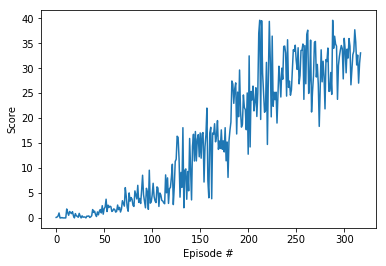

In [7]:
scores = train_agent(env, agent, brain_name, n_episodes=NUM_EPISODES, success_score=SUCCESS_SCORE, scores=scores)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

With random seed 0, this DDPG agent solves the task in the 318 episodes. The below figure is the plot of average scores along episodes.

![title](outputs/scores_318.png)

### 5. Infer the agent

In [9]:
tag = 'success'
model_path = 'models/{0}_{1}.pth'
actor_model_path = model_path.format('actor', tag)
critic_model_path = model_path.format('critic', tag)

if os.path.isfile(actor_model_path) & os.path.isfile(critic_model_path):
    agent.load_actor(actor_model_path)
    agent.load_critic(critic_model_path)
    print('Complete to load models from {0} | {1}'.format(actor_model_path, critic_model_path))

Complete to load models from models/actor_success.pth | models/critic_success.pth


Episode 100	Average Score: 33.55


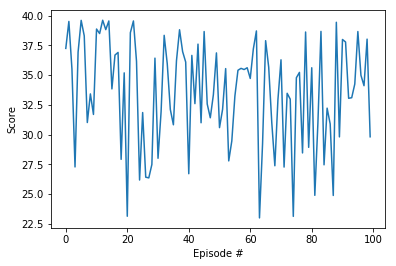

In [10]:
scores = infer_agent(env, agent, brain_name, n_episodes=100)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [7]:
env.close()